# Loading data

In [1]:
import tensorflow as tf
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

import numpy as np

def to_one_hot(y, num_class=10):
  master = []
  for value in y[:,0]:
    row = np.zeros(num_class)
    row[value] = 1
    master.append(row)
  return np.array(master)

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

import numpy 
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

170500096/170498071 [==============================] - 6s 0us/step
Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


Models (we will not train them, but instead, use weights we got from our training notebooks)

In [2]:
ResNet = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/RN_arch.h5")
ResNet.load_weights("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/ResNet.h5")

noisy_ResNet = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/RN_arch.h5")
noisy_ResNet.load_weights("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/ResNet_Noisy.h5")

modelRN_deep = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/DeepRN_arch.h5")
modelRN_deep.load_weights("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/DeepResNet.h5")

noisy_modelRN_deep = tf.keras.models.load_model("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/DeepRN_arch.h5")
noisy_modelRN_deep.load_weights("/content/drive/MyDrive/Trick_NN/Models/CIFAR_Models/DeepResNet_Noisy.h5")

In [3]:
cands = [16,21, 1423, 13,131,5300,6211,4511,7023,3125]
labs = ["Dog", "Plane", "Deer", "Horse", "Automobile", "Truck", "Ship", "Frog", "Bird", "Cat"]

In [7]:
labels_mapping = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]
models = [ResNet, noisy_ResNet, modelRN_deep, noisy_modelRN_deep]

In [8]:
cands = [16,21, 1423, 13,131,5300,6211,4511,7023,3125]
for model in models:
  a = model.evaluate(x_test[cands],y_test_vec[cands])
  print(a)

1/1 [==============================] - 17s 17s/step - loss: 0.0070 - acc: 1.0000
[0.006990577094256878, 1.0]
1/1 [==============================] - 1s 566ms/step - loss: 0.0065 - acc: 1.0000
[0.006482011638581753, 1.0]
1/1 [==============================] - 1s 986ms/step - loss: 0.0049 - acc: 1.0000
[0.004932035226374865, 1.0]
1/1 [==============================] - 1s 680ms/step - loss: 0.0561 - acc: 1.0000
[0.056101322174072266, 1.0]


# Attacking

In [9]:
from copy import deepcopy
langs = list(range(0,10))


models_master_hist = []

for cnt10, model in enumerate(models):
  print("New Model")
  master_hist = []
  for i in cands:
    print(i)
    digit = x_test[i]
    y_true = y_test_vec[i]
    digit = digit.astype("float32")
    #untargeted
    import numpy
    import keras
    digit2 = digit.reshape((1,32,32,3)).copy()
    true_target = y_true.copy()

    lr = 0.01

    decay = 0.0005

    hist = [digit2]
    histp = [model.predict(digit2)]
    for t in range(1000):
      # gradient descent
      fake_img2 = digit2.reshape((1,32,32,3)).copy() # initialize
      fake_img = tf.Variable(fake_img2)

      with tf.GradientTape() as tape:
        tape.watch(fake_img)

        pred = model(fake_img)
        loss = keras.metrics.binary_crossentropy(pred, true_target)


      grad = tape.gradient(loss, fake_img)
      g = tf.sign(grad).numpy()
      #g = grad / np.max(numpy.abs(grad))
      g[g==0] = np.random.rand()
      g = np.nan_to_num(g, copy=True, nan = 1)
      #print(type(g))
      digits3 = digit2 + lr*g
      np.argmax(digits3)
      digit2 = digits3
      digit2[digit2 < 0] = 0
      digit2[digit2 > 255] = 255
      hist.append(digit2)
      histp.append(model.predict(digit2))

      lr = lr/(lr + decay*t)
      #print(lr)

      if np.argmax(pred.numpy()) != np.argmax(true_target) and np.max(pred.numpy()) > 0.9:
        print("Achieved at", t, loss.numpy())
        break
    master_hist.append([deepcopy(hist), deepcopy(histp)])
  models_master_hist.append(master_hist)
#plt.show()

New Model
16
Achieved at 4 [3.05445331]
21
Achieved at 5 [2.89666892]
1423
Achieved at 5 [3.08377999]
13
Achieved at 14 [3.08498883]
131
Achieved at 4 [3.08213885]
5300
Achieved at 4 [3.08190149]
6211
Achieved at 6 [3.05436745]
4511
Achieved at 5 [3.05831214]
7023
Achieved at 7 [3.08488537]
3125
Achieved at 3 [2.99289874]
New Model
16
Achieved at 4 [3.07879711]
21
Achieved at 4 [2.83328074]
1423
Achieved at 2 [3.01269925]
13
Achieved at 10 [3.08498978]
131
Achieved at 4 [2.95753711]
5300
Achieved at 5 [3.01421719]
6211
Achieved at 5 [2.91332089]
4511
Achieved at 4 [3.08245583]
7023
Achieved at 3 [2.85954546]
3125
Achieved at 4 [3.06177356]
New Model
16
Achieved at 5 [3.08246376]
21
Achieved at 3 [3.06876974]
1423
Achieved at 4 [3.08497938]
13
Achieved at 6 [3.06845886]
131
Achieved at 4 [3.05250078]
5300
Achieved at 9 [3.08498194]
6211
Achieved at 6 [3.0821643]
4511
Achieved at 4 [3.07161902]
7023
Achieved at 4 [3.07554059]
3125
Achieved at 3 [3.05644853]
New Model
16
Achieved at 4 [3.

In [10]:
imgs = []

for cnt in range(10):
  ims = [x[cnt][0][-1] for x in  models_master_hist]
  ims.append(models_master_hist[0][cnt][0][0])
  imgs.append(ims)

In [11]:
labs = []
for cnt in range(10):
  lab = [labels_mapping[np.argmax(x[cnt][1][-1])] for x in  models_master_hist]
  lab.append(labels_mapping[np.argmax(models_master_hist[0][cnt][1][0])])
  labs.append(lab)

In [12]:
labs

[['cat', 'cat', 'bird', 'truck', 'dog'],
 ['bird', 'bird', 'bird', 'bird', 'airplane'],
 ['airplane', 'bird', 'airplane', 'cat', 'deer'],
 ['dog', 'cat', 'automobile', 'truck', 'horse'],
 ['truck', 'truck', 'truck', 'truck', 'automobile'],
 ['automobile', 'automobile', 'deer', 'automobile', 'truck'],
 ['truck', 'airplane', 'deer', 'bird', 'ship'],
 ['bird', 'cat', 'automobile', 'cat', 'frog'],
 ['dog', 'airplane', 'dog', 'dog', 'bird'],
 ['frog', 'truck', 'truck', 'truck', 'cat']]

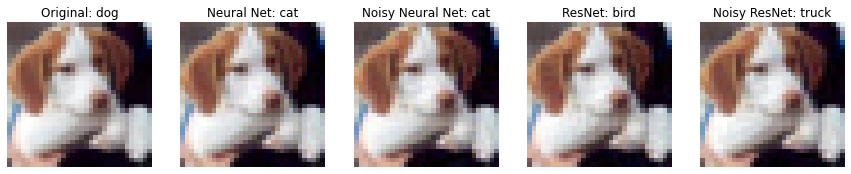

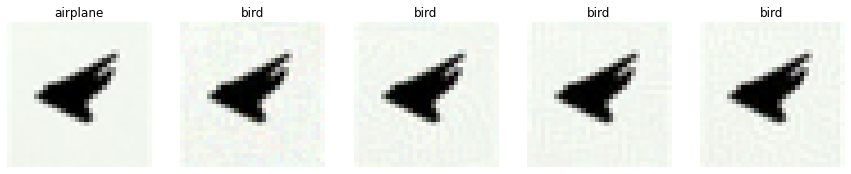

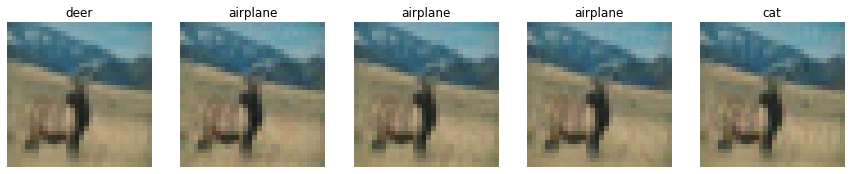

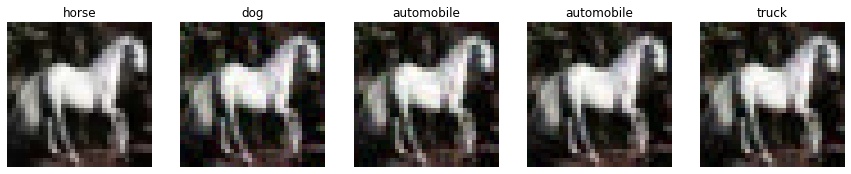

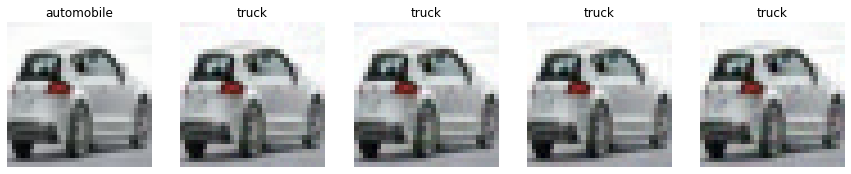

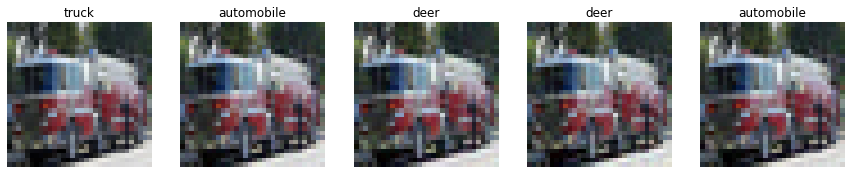

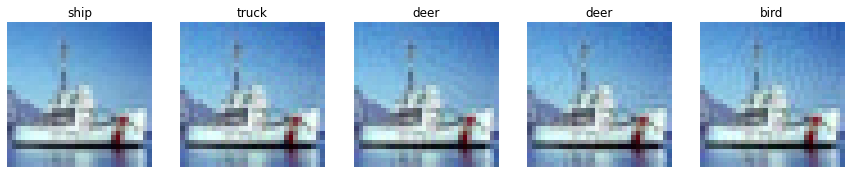

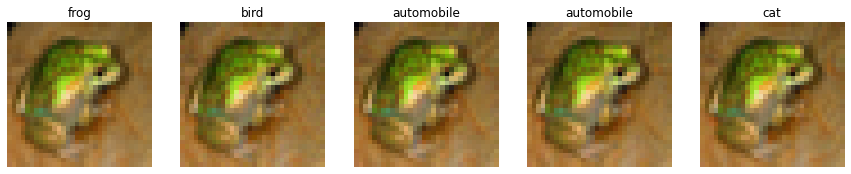

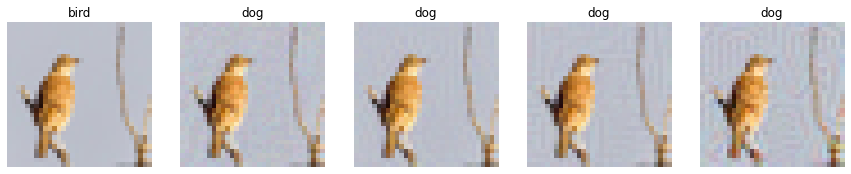

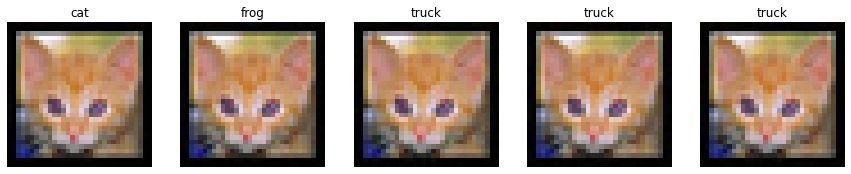

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt


for cnt,imset in enumerate(imgs):
  fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1,5)
  fig.set_figheight(10)
  fig.set_figwidth(15)
  img1 = ax1.imshow(imset[4].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img2 = ax2.imshow(imset[0].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img3 = ax3.imshow(imset[1].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img4 = ax4.imshow(imset[2].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img5 = ax5.imshow(imset[3].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  ax5.axis('off')
  if cnt == 0:
    ax1.set_title("Original: " + labs[cnt][-1])
    ax2.set_title("Neural Net: "+ labs[cnt][0])
    ax3.set_title("Noisy Neural Net: " + labs[cnt][1])
    ax4.set_title("ResNet: "+ labs[cnt][2])
    ax5.set_title("Noisy ResNet: "+ labs[cnt][3])
  else:
    ax1.set_title( labs[cnt][-1])
    ax2.set_title(labs[cnt][0])
    ax3.set_title(labs[cnt][2])
    ax4.set_title(labs[cnt][2])
    ax5.set_title(labs[cnt][3])
  

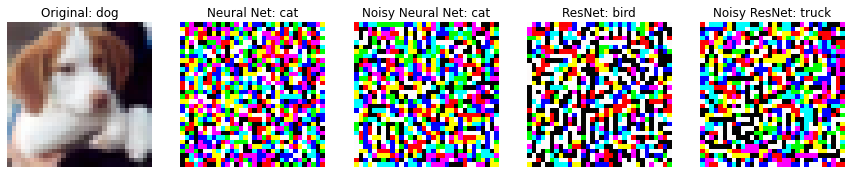

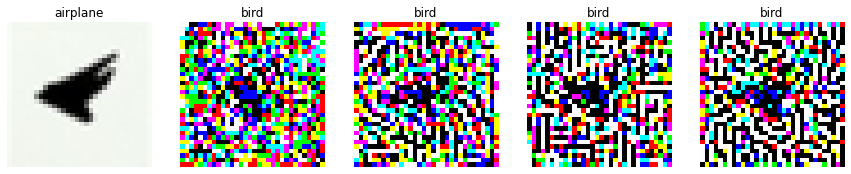

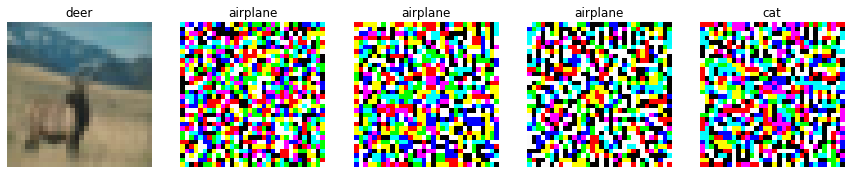

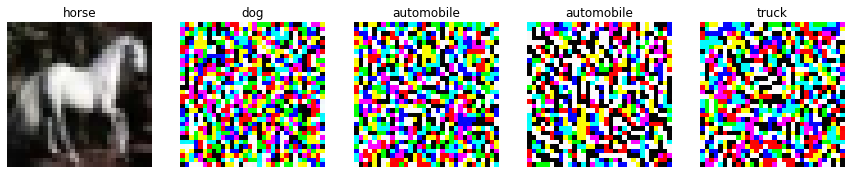

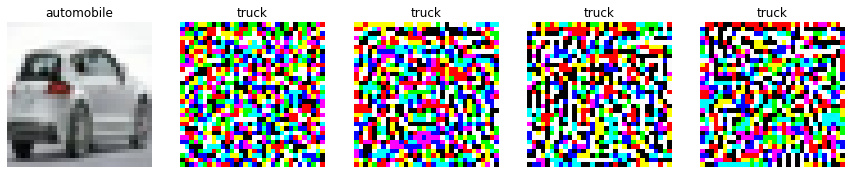

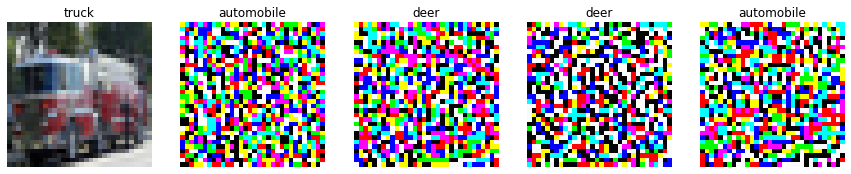

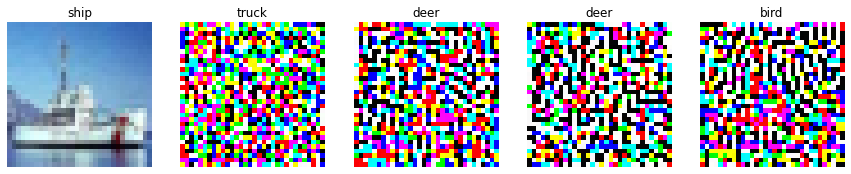

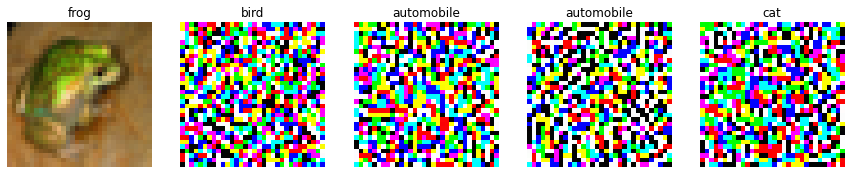

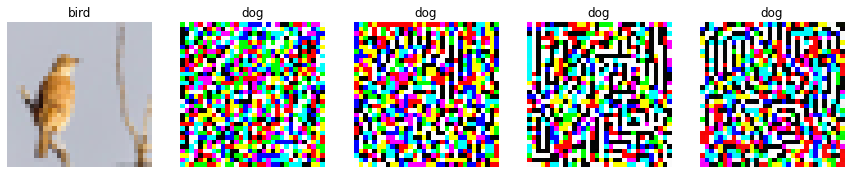

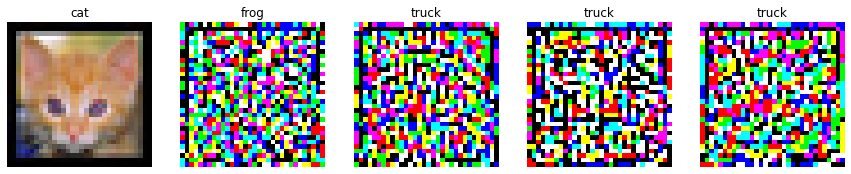

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt


for cnt,imset in enumerate(imgs):
  fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1,5)
  fig.set_figheight(10)
  fig.set_figwidth(15)
  img1 = ax1.imshow(imset[4].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img2 = ax2.imshow(imset[0].reshape((32, 32, 3)).astype("uint8") - imset[4].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img3 = ax3.imshow(imset[1].reshape((32, 32, 3)).astype("uint8") - imset[4].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img4 = ax4.imshow(imset[2].reshape((32, 32, 3)).astype("uint8") - imset[4].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  img5 = ax5.imshow(imset[3].reshape((32, 32, 3)).astype("uint8")- imset[4].reshape((32, 32, 3)).astype("uint8"), cmap = "gray")
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  ax5.axis('off')
  if cnt == 0:
    ax1.set_title("Original: " + labs[cnt][-1])
    ax2.set_title("Neural Net: "+ labs[cnt][0])
    ax3.set_title("Noisy Neural Net: " + labs[cnt][1])
    ax4.set_title("ResNet: "+ labs[cnt][2])
    ax5.set_title("Noisy ResNet: "+ labs[cnt][3])
  else:
    ax1.set_title( labs[cnt][-1])
    ax2.set_title(labs[cnt][0])
    ax3.set_title(labs[cnt][2])
    ax4.set_title(labs[cnt][2])
    ax5.set_title(labs[cnt][3])

In [ ]:
goods = []

for cnt in range(1000):

  print(labels_mapping[y_test[cnt][0]])
  cands = [cnt]

  if len(goods) >= 100:
    break

  check = True

  for model in models:
    a = model.evaluate(x_test[cands],y_test_vec[cands])
    if a[1] != 1:
      check = False
  
  #print(labels_mapping[y_test[num][0]])
  #plt.imshow(x_test[num])

  if check:
    goods.append(cnt)

In [ ]:
from copy import deepcopy
langs = list(range(0,10))


models_master_hist = []

for cnt10, model in enumerate(models):
  print("New Model")
  master_hist = []
  for i in goods[:100]:
    print(i)
    digit = x_test[i]
    y_true = y_test_vec[i]
    digit = digit.astype("float32")
    #untargeted
    import numpy
    import keras
    digit2 = digit.reshape((1,32,32,3)).copy()
    true_target = y_true.copy()

    lr = 0.01

    decay = 0.0005

    hist = [digit2]
    histp = [model.predict(digit2)]
    for t in range(1000):
      # gradient descent
      fake_img2 = digit2.reshape((1,32,32,3)).copy() # initialize
      fake_img = tf.Variable(fake_img2)

      with tf.GradientTape() as tape:
        tape.watch(fake_img)

        pred = model(fake_img)
        loss = keras.metrics.binary_crossentropy(pred, true_target)


      grad = tape.gradient(loss, fake_img)
      g = tf.sign(grad).numpy()
      #g = grad / np.max(numpy.abs(grad))
      g[g==0] = np.random.rand()
      g = np.nan_to_num(g, copy=True, nan = 1)
      #print(type(g))
      digits3 = digit2 + lr*g
      np.argmax(digits3)
      digit2 = digits3
      digit2[digit2 < 0] = 0
      digit2[digit2 > 255] = 255
      hist.append(digit2)
      histp.append(model.predict(digit2))

      lr = lr/(lr + decay*t)
      #print(lr)

      if np.argmax(pred.numpy()) != np.argmax(true_target) and np.max(pred.numpy()) > 0.9:
        break
    master_hist.append([deepcopy(hist), deepcopy(histp)])
  models_master_hist.append(master_hist)
#plt.show()

In [17]:
imgs = []

for cnt in range(100):
  ims = [x[cnt][0][-1] for x in  models_master_hist]
  ims.append(models_master_hist[0][cnt][0][0])
  imgs.append(ims)

In [18]:
diffs = [0,0,0,0,0]
nandiffs = [0,0,0,0,0]
deltaPix = [0,0,0,0,0]



for cnt,imset in enumerate(imgs):
  for cnt2, im in enumerate(imset):
    mn = np.mean(abs(imset[cnt2] - imset[-1]))
    #print(mn)
    diffs[cnt2] += mn
    ds = imset[cnt2] - imset[-1]
    ds2 = ds.reshape((1024,3))
    thresh = 7.5
    deltaPix[cnt2] += np.count_nonzero(ds2.sum(axis=1) > thresh, axis=0)
    data = abs(imset[cnt2] - imset[-1])
    data[data == 0] = np.nan
    mn = np.nanmean(data)
    nandiffs[cnt2] += mn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


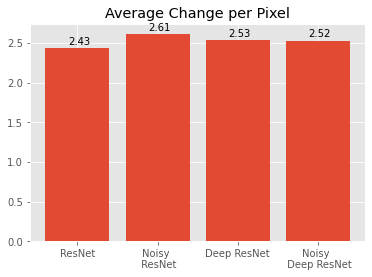

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

y = [x/100 for x in diffs][:-1]


plt.bar(["ResNet", "Noisy \n ResNet", "Deep ResNet", "Noisy \n Deep ResNet"],  y)

xlocs, xlabs = plt.xticks()

plt.title("Average Change per Pixel")

for i, v in enumerate(y):
    plt.text(xlocs[i]- 0.12, v + 0.05, str(v)[:4])

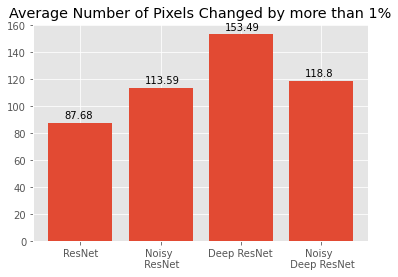

In [20]:
y = [x/100 for x in deltaPix][:-1]
plt.bar(["ResNet", "Noisy \n ResNet", "Deep ResNet", "Noisy \n Deep ResNet"], y )

xlocs, xlabs = plt.xticks()

plt.title("Average Number of Pixels Changed by more than 1%")


for i, v in enumerate(y):
    plt.text(xlocs[i]- 0.2, v + 3, str(v)[:6])

In [21]:
diffs = [0,0,0,0,0]
nandiffs = [0,0,0,0,0]
deltaPix = [0,0,0,0,0]



for cnt,imset in enumerate(imgs):
  for cnt2, im in enumerate(imset):
    mn = np.mean(abs(imset[cnt2] - imset[-1]))
    #print(mn)
    diffs[cnt2] += mn
    ds = imset[cnt2] - imset[-1]
    ds2 = ds.reshape((1024,3))
    thresh = 0
    deltaPix[cnt2] += np.count_nonzero(ds2.sum(axis=1) > thresh, axis=0)
    data = abs(imset[cnt2] - imset[-1])
    data[data == 0] = np.nan
    mn = np.nanmean(data)
    nandiffs[cnt2] += mn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


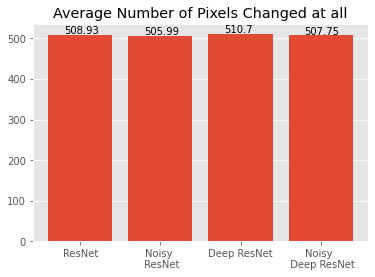

In [22]:
y = [x/100 for x in deltaPix][:-1]
plt.bar(["ResNet", "Noisy \n ResNet", "Deep ResNet", "Noisy \n Deep ResNet"], y )

xlocs, xlabs = plt.xticks()

plt.title("Average Number of Pixels Changed at all")


for i, v in enumerate(y):
    plt.text(xlocs[i]- 0.2, v + 3, str(v)[:6])

In [23]:
from keras.utils.vis_utils import plot_model

In [29]:
len(modelRN_deep.layers)

151